# Image Classification on CIFAR-10 (transfer-learning) in Amazon SageMaker

We use **transfer learning mode** in Sagemaker to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new dataset. The pre-trained model (ImageNet) will be fine-tuned using CIFAR-10 dataset.

#### Prequisites

1. Set up AWS authentication to Jupyter notebook
2. We would need AWS S3 bucket
The Amazon sagemaker image classification docker image which need not be changed

In [1]:
import urllib.request
import time
from time import gmtime, strftime
import boto3
from sagemaker import get_execution_role
import re
import os

In [2]:
%%time

role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

bucket='hyunjoon-sagemaker-us' # your own S3 bucket (make sure to select the bucket in the same region)

# Pre-defind contatiners that has image classfication algorithms
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}

Wall time: 0 ns


In [3]:
training_image = containers[boto3.Session().region_name]
print(training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest


In [4]:
boto3.Session()

Session(region_name='us-west-2')

In [5]:
boto3.Session().client(service_name='sagemaker') 

# 1. Load Data

We use the recordio format of CIFAR-10 dataset

**boto3** Package provides handy function to upload data/objects to previously created S3 buckets

In [6]:
# Helper functions
def download(url):
    filename = url.split("/")[-1] # Extract filename from URL
    if not os.path.exists(filename): # Create directory
        urllib.request.urlretrieve(url, filename)
        
def upload_to_s3_bucket(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

download('http://data.mxnet.io/data/cifar10/cifar10_train.rec') # recordio format of CIFAR-10 training dataset
download('http://data.mxnet.io/data/cifar10/cifar10_val.rec') # recordio format of CIFAR-10 validation dataset

# Upload dataset to s3 bucket created in AWS console
upload_to_s3_bucket('validation/cifar10', 'cifar10_val.rec')
upload_to_s3_bucket('train/cifar10', 'cifar10_train.rec')

# 2. Set Hyper Parameters 

In [10]:
num_layers = 50              # this supports multiple layers (18, 34, 50, 101, 152, 200)

image_shape = "3,28,28"      # input image shape
num_training_samples = 50000 # for CIFAR-10 it is 50000
num_classes = 10
mini_batch_size =  128       # batch size 
epochs = 5                   # Your epoach (most cases > 100)
optimizer='adam'
learning_rate = 0.01
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be replaced with pre-trained weights
# Set use_pretrained_model = 0 to disable the transfer learning
use_pretrained_model = 1

# 3. Train the dataset with Sagemaker

We need to create 'CreateTrainingJob API'

In [11]:
%%time

s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'sagemaker-imageclassification-cifar10'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": 'ml.p2.xlarge', 
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "optimizer":optimizer,
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fully- replicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train/cifar10'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation/cifar10'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: sagemaker-imageclassification-cifar10-2020-06-19-00-19-11

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://hyunjoon-sagemaker-us/train/cifar10', 'S3DataDistributionType': 'FullyReplicated'}
Wall time: 4.99 ms


In [14]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')

# Create a Training job in SageMaker
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [15]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


Training sucessfully completed and the output model was stored in the output path specified by training_params ['OutputDataConfig'].

You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab.

# 4. Check the loss graph

In [17]:
print(job_name)

sagemaker-imageclassification-cifar10-2020-06-19-00-19-11


Maximum validation accuracy: 0.554387 


<Figure size 432x288 with 0 Axes>

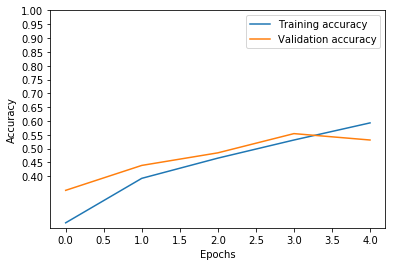

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

client = boto3.client('logs')

lgn='/aws/sagemaker/TrainingJobs'

# Update this with the actual name in your CloudWatch logs #
lsn=job_name+'/'+'algo-1-1592526464'

log=client.get_log_events(logGroupName=lgn, logStreamName=lsn)

trn_accs=[]
val_accs=[]
for e in log['events']:
    msg=e['message']
    if 'Validation-accuracy' in msg:
        val = msg.split("=")
        val = val[1]
        val_accs.append(float(val))
    if 'Train-accuracy' in msg:
        trn = msg.split("=")
        trn = trn[1]
        trn_accs.append(float(trn))

print("Maximum validation accuracy: %f " % max(val_accs))   

plt.clf()
fig, ax = plt.subplots()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
trn_plot, = ax.plot(range(epochs), trn_accs, label="Training accuracy")
val_plot, = ax.plot(range(epochs), val_accs, label="Validation accuracy")
plt.legend(handles=[trn_plot,val_plot])
ax.yaxis.set_ticks(np.arange(0.4, 1.05, 0.05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.show()

# 5. Deploy the trained model

Before we actually perform an inference on test-set, SageMaker goes through 4 steps

1. Create Model - Create model for the training output \
2. Create Endpoint Configuration - Create a configuration defining an endpoint. \
3. Create Endpoint - Use the configuration to create an inference endpoint. \
4. Perform Inference - Perform inference on some input data using the endpoint.

#### 5.1 Create Model

Below codeset creates a model with the best training job

![model]('./img/model.png')

In [19]:
%%time

sage = boto3.Session().client(service_name='sagemaker') 

model_name="image-classification-cifar-transfer"
print('model_name is :', model_name)

info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']

print('model_data is :', model_data)
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}

hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

model_name is : image-classification-cifar-transfer
model_data is : s3://hyunjoon-sagemaker-us/sagemaker-imageclassification-cifar10/output/sagemaker-imageclassification-cifar10-2020-06-19-00-19-11/output/model.tar.gz
arn:aws:sagemaker:us-west-2:570447867175:model/image-classification-cifar-transfer
Wall time: 794 ms


#### 5.2 Create Endpoint Configuration

To actually deploy our product online, the trained model nees should have REST endpoints. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

![endpoint]('./img/endpoint_config.png')

In [21]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: sagemaker-imageclassification-cifar10-epc--2020-06-19-00-44-49
Endpoint configuration arn:  arn:aws:sagemaker:us-west-2:570447867175:endpoint-config/sagemaker-imageclassification-cifar10-epc--2020-06-19-00-44-49


#### 5.2 Create Endpoint 

Create the endpoint that serves the model, through specifying the name and configuration defined in codes above. 

![endpoint]('./img/endpoint.png')

In [22]:
%%time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: sagemaker-imageclassification-cifar10-ep--2020-06-19-00-46-29
EndpointArn = arn:aws:sagemaker:us-west-2:570447867175:endpoint/sagemaker-imageclassification-cifar10-ep--2020-06-19-00-46-29
Wall time: 493 ms


#####  get the status of the endpoint

In [23]:
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


# 6. Evaluate the model 

### Eventually, we need to create a **runtime** object where we can invoke the endpoint.

In [24]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker')

##### Test out with a sample image

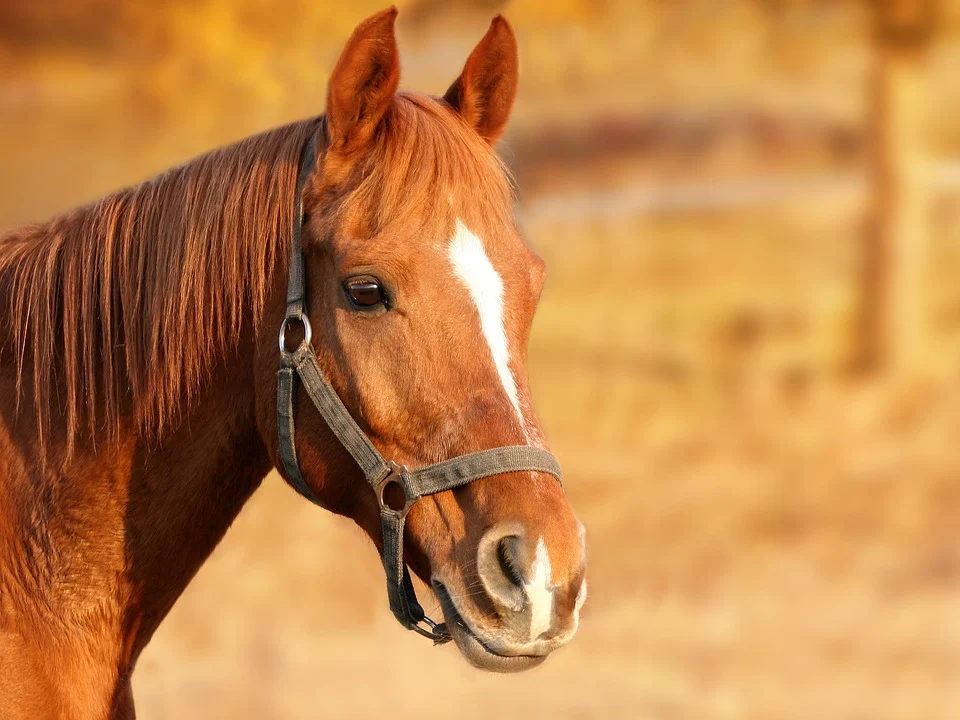

In [27]:
file_name = './img/horse.png'
# test image
from IPython.display import Image
Image(file_name)

In [28]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
print(result)

[0.011687035672366619, 0.0035697277635335922, 0.08615817874670029, 0.27339035272598267, 0.13080066442489624, 0.21800114214420319, 0.06971503794193268, 0.19917337596416473, 0.0011441635433584452, 0.00636028777807951]


In [30]:
# Find the class with maximum probability 
index = np.argmax(result)
object_categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - cat, probability - 0.27339035272598267


Of course I only trained the model for 5 epoch for demo purpose, the result is definitely not what we want see, (the above loss plot also shows that the accuracy is only around 50%) /
But this will of course improve with more training epoch

**IMPORTANT!!**

# 7. CLose the SageMaker Instance

To make sure we don't get charged after the training/inference is over, we have to delete the endpoint.

In [36]:
print(endpoint_name)
sage.delete_endpoint(EndpointName=endpoint_name)
sage.delete_endpoint_config(EndpointConfigName=endpoint_name)
sage.delete_model(ModelName=endpoint_name)

sagemaker-imageclassification-cifar10-ep--2020-06-19-00-46-29


{'ResponseMetadata': {'RequestId': '8aa4f856-c474-4e23-9fe6-e97f7ce6134a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8aa4f856-c474-4e23-9fe6-e97f7ce6134a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 19 Jun 2020 01:00:40 GMT'},
  'RetryAttempts': 0}}